<a href="https://www.kaggle.com/code/tahayassinetizaoui/cmpt-rndu-dl-tizaoui-taha-yassine-ayadi-yassine?scriptVersionId=94862616" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Compte rendu 


In [1]:
import numpy as np
import pandas as pd 

**Importing packages**

In [2]:
import re 
import nltk 
from nltk.corpus import stopwords 
from numpy import array 
from keras.preprocessing.text import one_hot 
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential,Model 
from keras.layers.core import Activation, Dropout, Dense 
from keras.layers import Flatten
from keras.layers import Conv1D 
from keras.layers import GlobalMaxPooling1D,MaxPooling1D
from keras.layers import LSTM,GRU
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split 
from keras.preprocessing.text import Tokenizer
from gensim.models import KeyedVectors


## Importation du dataset

In [3]:
train=pd.read_csv('../input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv')

**dimension :**

In [4]:
train.shape

(50000, 2)

**les valeurs NULL:**

In [5]:
train.isnull().sum()

review       0
sentiment    0
dtype: int64

**Exploration du dataset :**

In [6]:
train.head(5)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


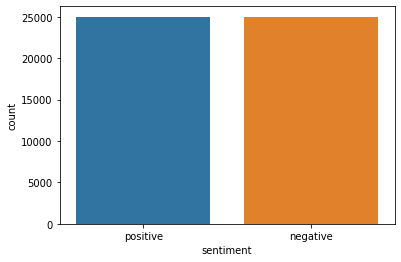

In [7]:
import seaborn as sns
ax=sns.countplot(x="sentiment", data=train)

In [8]:
train['review'].iloc[3]

"Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.<br /><br />OK, first of all when you're going to make a film you must Decide if its a thriller or a drama! As a drama the movie is watchable. Parents are divorcing & arguing like in real life. And then we have Jake with his closet which totally ruins all the film! I expected to see a BOOGEYMAN similar movie, and instead i watched a drama with some meaningless thriller spots.<br /><br />3 out of 10 just for the well playing parents & descent dialogs. As for the shots with Jake: just ignore them."

## Prétraitement de données :


In [9]:
def remove_tags(text):
 return TAG_RE.sub('', text)
def preprocess_text(sen):
# Removing html tags
 sentence = remove_tags(sen)
# Remove punctuations and numbers
 sentence = re.sub('[^a-zA-Z]', ' ', sentence)
# Single character removal
 sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)
# Removing multiple spaces
 sentence = re.sub(r'\s+', ' ', sentence)
 return sentence

TAG_RE = re.compile(r'<[^>]+>')


In [10]:
X = []
sentences = list(train['review'])
for sen in sentences:
 X.append(preprocess_text(sen))

In [11]:
X[3]

'Basically there a family where little boy Jake thinks there a zombie in his closet his parents are fighting all the time This movie is slower than soap opera and suddenly Jake decides to become Rambo and kill the zombie OK first of all when you re going to make film you must Decide if its thriller or drama As drama the movie is watchable Parents are divorcing arguing like in real life And then we have Jake with his closet which totally ruins all the film expected to see BOOGEYMAN similar movie and instead watched drama with some meaningless thriller spots out of just for the well playing parents descent dialogs As for the shots with Jake just ignore them '

In [12]:
y = train['sentiment']
y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
test_size=0.20, random_state=42)

## La couche de l’embedding :


In [14]:
tokenizer = Tokenizer(num_words=5000) 
tokenizer.fit_on_texts(X_train) 
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [15]:
# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1 
maxlen = 100 
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen) 
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [16]:
X_train

array([[   4,    1,  296, ...,  198,  345, 3812],
       [   1,  412,  100, ...,   82,   99,    6],
       [ 128, 1307,  108, ...,    0,    0,    0],
       ...,
       [ 778,    8,   24, ...,    0,    0,    0],
       [   8,  347,   10, ...,    0,    0,    0],
       [ 274,  100,  121, ...,   67,   69, 1946]], dtype=int32)

In [17]:
from numpy import array 
from numpy import asarray 
from numpy import zeros

def embeddings(path):
    embeddings_dictionary = dict() 
    embeddings_file = open(path) 
    for line in embeddings_file:
        records = line.split()
        word = records[0] 
        vector_dimensions = asarray(records[1:],dtype='float32') 
        embeddings_dictionary[word] = vector_dimensions
    embeddings_file.close()
    return embeddings_dictionary
embeddings_dictionary=embeddings("../input/glove6b100dtxt/glove.6B.100d.txt")

In [18]:
import matplotlib.pyplot as plt
def plotting(history):
    plt.plot(history.history['acc']) 
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc='upper left') 
    plt.show() 
    plt.plot(history.history['loss']) 
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss') 
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc='upper left') 
    plt.show()

## Les modèles : 

**A-Simple model**

In [19]:
def model_simple(X_train,y_train,embedding_matrix):
    model=Sequential()
    model.add(Embedding(vocab_size,100,weights=[embedding_matrix],input_length=maxlen,trainable=False))
    model.add(Flatten())
    model.add(Dense(1,activation='sigmoid'))
    model.compile("adam",loss='binary_crossentropy',metrics=["acc"])
    history=model.fit(X_train,y_train,epochs=6,batch_size=128,verbose=1,validation_split=0.2)
    return model,history


**B-CNN model**

In [20]:
def model_cnn(X_train,y_train):
    model_cnn=Sequential()

    model_cnn.add(Embedding(vocab_size, 100, weights=[embedding_matrix],input_length=maxlen))
    model_cnn.add(Conv1D(128,5,activation='relu'))
    model_cnn.add(GlobalMaxPooling1D())
    model_cnn.add(Dense(1,activation='sigmoid'))
    model_cnn.compile(loss='binary_crossentropy',optimizer='adam',metrics=['acc'])
    history=model_cnn.fit(X_train,y_train,epochs=6,batch_size=128,verbose=1,validation_split=0.2)
    return model_cnn,history

        

**C-RNN model**

In [21]:
def model_LSTM(X_train,y_train,l,embedding_matrix):
    model_rnn=Sequential()
    model_rnn.add(Embedding(vocab_size, l, weights=[embedding_matrix],input_length=maxlen,trainable=False))
    model_rnn.add(LSTM(128))
    model_rnn.add(Dense(1,activation='sigmoid'))
    model_rnn.compile(loss='binary_crossentropy',optimizer='adam',metrics=['acc'])
    history=model_rnn.fit(X_train,y_train,epochs=6,batch_size=128,verbose=1,validation_split=0.2)
    return model_rnn,history

**D-RNN with GRU**

In [22]:
def model_GRU(X_train,y_train,l,embedding_matrix):
    model_rnn=Sequential()
    model_rnn.add(Embedding(vocab_size, l, weights=[embedding_matrix],input_length=maxlen,trainable=False))
    model_rnn.add(GRU(128))
    model_rnn.add(Dense(1,activation='sigmoid'))
    model_rnn.compile(loss='binary_crossentropy',optimizer='adam',metrics=['acc'])
    history=model_rnn.fit(X_train,y_train,epochs=6,batch_size=128,verbose=1,validation_split=0.2)
    return model_rnn,history

**E-RNN+CNN**



In [23]:
def model_RNNCNN(X_train,y_train,l,embedding_matrix):
    modelx = Sequential()
    modelx.add((Embedding(vocab_size,l, weights=[embedding_matrix],input_length=maxlen,trainable=False)))
    modelx.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
    modelx.add(MaxPooling1D(pool_size=2))
    modelx.add(LSTM(128))
    modelx.add(Dense(1, activation='sigmoid'))
    modelx.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
    history=modelx.fit(X_train,y_train,epochs=6,batch_size=128,verbose=1,validation_split=0.2)
    return modelx,history

## Embeedings and testing with each one: 

## Glove

In [24]:
embedding_matrix_glove = zeros((vocab_size, 100)) 
for word, index in tokenizer.word_index.items(): 
    embedding_vector = embeddings_dictionary.get(word) 
    if embedding_vector is not None: 
        embedding_matrix_glove[index] = embedding_vector

In [25]:
embedding_matrix_glove

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.038194  , -0.24487001,  0.72812003, ..., -0.1459    ,
         0.82779998,  0.27061999],
       [-0.071953  ,  0.23127   ,  0.023731  , ..., -0.71894997,
         0.86894   ,  0.19539   ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.37771001,  0.22946   , -0.30311   , ..., -0.33610001,
         0.02637   , -0.72302002],
       [ 0.99882001,  0.044     ,  0.58508003, ..., -0.54869002,
         0.15141   ,  1.36880004]])

**modèle simple :**

In [26]:
model,history=model_simple(X_train,y_train,embedding_matrix_glove)

2022-05-05 20:47:26.234609: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-05 20:47:26.346685: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-05 20:47:26.347454: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-05 20:47:26.348703: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Epoch 1/6
250/250 [==============================] - 2s 3ms/step - loss: 0.6010 - acc: 0.6688 - val_loss: 0.5405 - val_acc: 0.7340
Epoch 2/6
250/250 [==============================] - 0s 2ms/step - loss: 0.4943 - acc: 0.7614 - val_loss: 0.5236 - val_acc: 0.7405
Epoch 3/6
250/250 [==============================] - 1s 2ms/step - loss: 0.4605 - acc: 0.7840 - val_loss: 0.5210 - val_acc: 0.7415
Epoch 4/6
250/250 [==============================] - 0s 2ms/step - loss: 0.4348 - acc: 0.7995 - val_loss: 0.5208 - val_acc: 0.7465
Epoch 5/6
250/250 [==============================] - 1s 2ms/step - loss: 0.4185 - acc: 0.8096 - val_loss: 0.5717 - val_acc: 0.7212
Epoch 6/6
250/250 [==============================] - 1s 2ms/step - loss: 0.4074 - acc: 0.8160 - val_loss: 0.5410 - val_acc: 0.7408


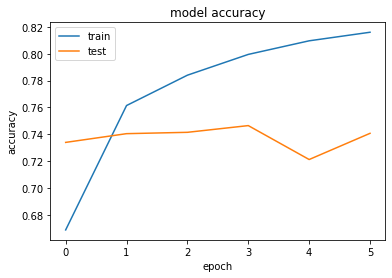

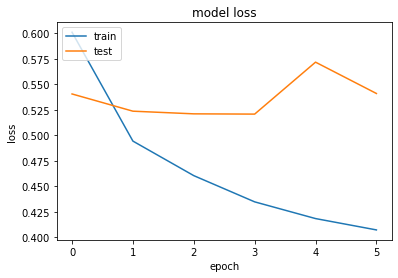

In [27]:
plotting(history)

In [28]:
score = model.evaluate(X_test, y_test, verbose=1)
print("Test Score:", score[0]) 
print("Test Accuracy:", score[1])

313/313 [==============================] - 0s 2ms/step - loss: 0.5447 - acc: 0.7387
Test Score: 0.544691801071167
Test Accuracy: 0.7386999726295471


**modèle LSTM :**

In [29]:
m,h=model_LSTM(X_train,y_train,100,embedding_matrix_glove)

Epoch 1/6


2022-05-05 20:47:37.650397: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


250/250 [==============================] - 5s 11ms/step - loss: 0.5612 - acc: 0.7012 - val_loss: 0.4865 - val_acc: 0.7690
Epoch 2/6
250/250 [==============================] - 2s 10ms/step - loss: 0.4510 - acc: 0.7893 - val_loss: 0.4094 - val_acc: 0.8141
Epoch 3/6
250/250 [==============================] - 2s 10ms/step - loss: 0.3993 - acc: 0.8178 - val_loss: 0.3743 - val_acc: 0.8304
Epoch 4/6
250/250 [==============================] - 2s 10ms/step - loss: 0.3641 - acc: 0.8372 - val_loss: 0.3677 - val_acc: 0.8363
Epoch 5/6
250/250 [==============================] - 2s 10ms/step - loss: 0.3420 - acc: 0.8497 - val_loss: 0.3545 - val_acc: 0.8450
Epoch 6/6
250/250 [==============================] - 2s 10ms/step - loss: 0.3238 - acc: 0.8601 - val_loss: 0.3403 - val_acc: 0.8536


In [30]:
score = m.evaluate(X_test, y_test, verbose=1)
print("Test Score:", score[0]) 
print("Test Accuracy:", score[1])

313/313 [==============================] - 1s 3ms/step - loss: 0.3336 - acc: 0.8532
Test Score: 0.333608478307724
Test Accuracy: 0.8532000184059143


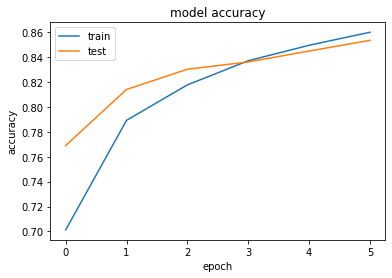

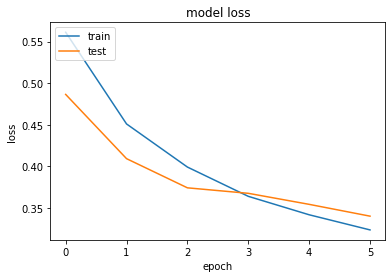

In [31]:
plotting(h)

**modèle GRU :**

In [32]:
m1,h1=model_GRU(X_train,y_train,100,embedding_matrix_glove)

Epoch 1/6
250/250 [==============================] - 4s 10ms/step - loss: 0.5407 - acc: 0.7162 - val_loss: 0.4383 - val_acc: 0.7971
Epoch 2/6
250/250 [==============================] - 2s 8ms/step - loss: 0.3930 - acc: 0.8204 - val_loss: 0.3769 - val_acc: 0.8338
Epoch 3/6
250/250 [==============================] - 2s 8ms/step - loss: 0.3632 - acc: 0.8370 - val_loss: 0.3541 - val_acc: 0.8416
Epoch 4/6
250/250 [==============================] - 2s 8ms/step - loss: 0.3359 - acc: 0.8523 - val_loss: 0.3364 - val_acc: 0.8522
Epoch 5/6
250/250 [==============================] - 2s 8ms/step - loss: 0.3178 - acc: 0.8629 - val_loss: 0.3364 - val_acc: 0.8566
Epoch 6/6
250/250 [==============================] - 2s 8ms/step - loss: 0.2970 - acc: 0.8714 - val_loss: 0.3205 - val_acc: 0.8604


In [33]:
score = m1.evaluate(X_test, y_test, verbose=1)
print("Test Score:", score[0]) 
print("Test Accuracy:", score[1])

313/313 [==============================] - 1s 4ms/step - loss: 0.3181 - acc: 0.8626
Test Score: 0.3180534541606903
Test Accuracy: 0.8626000285148621


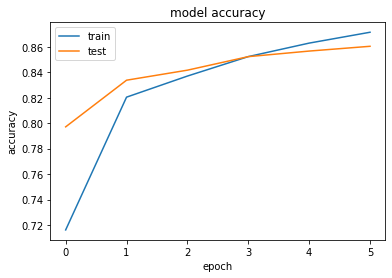

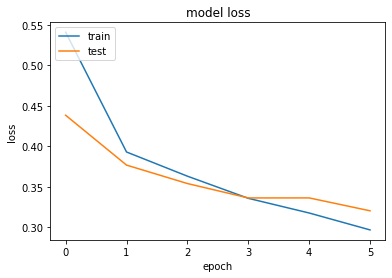

In [34]:
plotting(h1)

**modèle RNN+CNN :**

In [35]:
m2,h2=model_RNNCNN(X_train,y_train,100,embedding_matrix_glove)

Epoch 1/6
250/250 [==============================] - 8s 9ms/step - loss: 0.5499 - acc: 0.7028 - val_loss: 0.4168 - val_acc: 0.8108
Epoch 2/6
250/250 [==============================] - 2s 8ms/step - loss: 0.3985 - acc: 0.8202 - val_loss: 0.3656 - val_acc: 0.8347
Epoch 3/6
250/250 [==============================] - 2s 7ms/step - loss: 0.3450 - acc: 0.8476 - val_loss: 0.4174 - val_acc: 0.7980
Epoch 4/6
250/250 [==============================] - 2s 7ms/step - loss: 0.3152 - acc: 0.8639 - val_loss: 0.3433 - val_acc: 0.8471
Epoch 5/6
250/250 [==============================] - 2s 7ms/step - loss: 0.2692 - acc: 0.8880 - val_loss: 0.4395 - val_acc: 0.8071
Epoch 6/6
250/250 [==============================] - 2s 7ms/step - loss: 0.2315 - acc: 0.9048 - val_loss: 0.4149 - val_acc: 0.8242


In [36]:
score = m2.evaluate(X_test, y_test, verbose=1)
print("Test Score:", score[0]) 
print("Test Accuracy:", score[1])

313/313 [==============================] - 1s 3ms/step - loss: 0.4147 - acc: 0.8242
Test Score: 0.4147171378135681
Test Accuracy: 0.8241999745368958


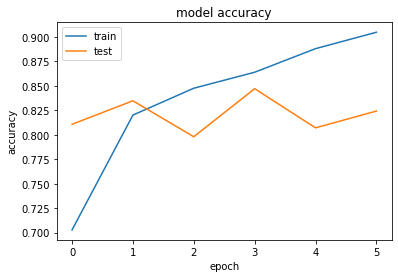

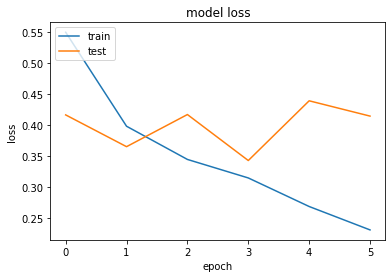

In [37]:
plotting(h2)

## Word2Vec

In [38]:
word2vec=embeddings("../input/original-embeddings/GoogleNews-vectors-negative300(first500000).txt")

In [39]:
embedding_matrix_w2v = zeros((vocab_size, 300)) 
for word, index in tokenizer.word_index.items(): 
    embedding_vector = word2vec.get(word) 
    if embedding_vector is not None: 
        embedding_matrix_w2v[index] = embedding_vector

In [40]:
embedding_matrix_w2v

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.08007812,  0.10498047,  0.04980469, ...,  0.00366211,
         0.04760742, -0.06884766],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

**modèle LSTM :**

In [41]:
m3,h3=model_LSTM(X_train,y_train,300,embedding_matrix_w2v)

Epoch 1/6
250/250 [==============================] - 5s 13ms/step - loss: 0.4575 - acc: 0.7807 - val_loss: 0.4117 - val_acc: 0.8227
Epoch 2/6
250/250 [==============================] - 3s 11ms/step - loss: 0.3908 - acc: 0.8254 - val_loss: 0.3763 - val_acc: 0.8288
Epoch 3/6
250/250 [==============================] - 3s 11ms/step - loss: 0.3705 - acc: 0.8364 - val_loss: 0.3465 - val_acc: 0.8446
Epoch 4/6
250/250 [==============================] - 3s 11ms/step - loss: 0.3515 - acc: 0.8453 - val_loss: 0.3878 - val_acc: 0.8242
Epoch 5/6
250/250 [==============================] - 3s 11ms/step - loss: 0.3365 - acc: 0.8536 - val_loss: 0.3240 - val_acc: 0.8583
Epoch 6/6
250/250 [==============================] - 3s 11ms/step - loss: 0.3158 - acc: 0.8631 - val_loss: 0.3185 - val_acc: 0.8625


In [42]:
score = m3.evaluate(X_test, y_test, verbose=1)
print("Test Score:", score[0]) 
print("Test Accuracy:", score[1])

313/313 [==============================] - 1s 4ms/step - loss: 0.3191 - acc: 0.8613
Test Score: 0.31906816363334656
Test Accuracy: 0.861299991607666


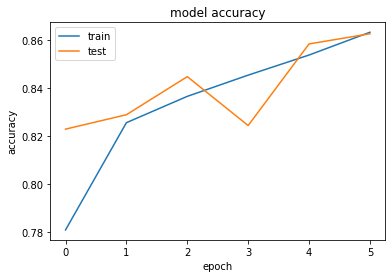

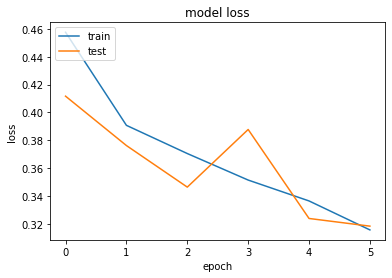

In [43]:
plotting(h3)

**modèle GRU :**

In [44]:
m4,h4=model_GRU(X_train,y_train,300,embedding_matrix_w2v)

Epoch 1/6
250/250 [==============================] - 4s 11ms/step - loss: 0.4723 - acc: 0.7680 - val_loss: 0.3860 - val_acc: 0.8319
Epoch 2/6
250/250 [==============================] - 3s 11ms/step - loss: 0.3660 - acc: 0.8373 - val_loss: 0.3363 - val_acc: 0.8546
Epoch 3/6
250/250 [==============================] - 2s 9ms/step - loss: 0.3347 - acc: 0.8537 - val_loss: 0.3265 - val_acc: 0.8580
Epoch 4/6
250/250 [==============================] - 2s 9ms/step - loss: 0.3219 - acc: 0.8584 - val_loss: 0.3143 - val_acc: 0.8612
Epoch 5/6
250/250 [==============================] - 2s 9ms/step - loss: 0.3071 - acc: 0.8684 - val_loss: 0.3147 - val_acc: 0.8636
Epoch 6/6
250/250 [==============================] - 2s 9ms/step - loss: 0.2966 - acc: 0.8740 - val_loss: 0.3123 - val_acc: 0.8648


In [45]:
score = m4.evaluate(X_test, y_test, verbose=1)
print("Test Score:", score[0]) 
print("Test Accuracy:", score[1])

313/313 [==============================] - 1s 3ms/step - loss: 0.3097 - acc: 0.8619
Test Score: 0.30972498655319214
Test Accuracy: 0.8618999719619751


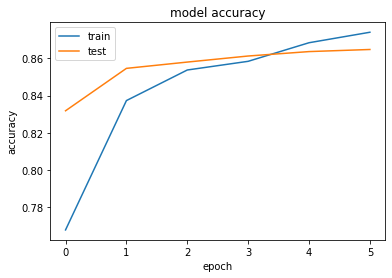

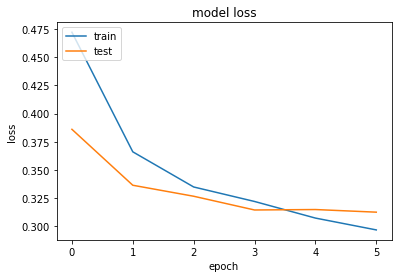

In [46]:
plotting(h4)

**modèle RNN+CNN :**

In [47]:
m5,h5=model_RNNCNN(X_train,y_train,300,embedding_matrix_w2v)

Epoch 1/6
250/250 [==============================] - 4s 10ms/step - loss: 0.4481 - acc: 0.7902 - val_loss: 0.3708 - val_acc: 0.8321
Epoch 2/6
250/250 [==============================] - 2s 9ms/step - loss: 0.3374 - acc: 0.8523 - val_loss: 0.3328 - val_acc: 0.8564
Epoch 3/6
250/250 [==============================] - 2s 9ms/step - loss: 0.2857 - acc: 0.8804 - val_loss: 0.3601 - val_acc: 0.8374
Epoch 4/6
250/250 [==============================] - 2s 10ms/step - loss: 0.2312 - acc: 0.9094 - val_loss: 0.3281 - val_acc: 0.8655
Epoch 5/6
250/250 [==============================] - 2s 9ms/step - loss: 0.1707 - acc: 0.9358 - val_loss: 0.5167 - val_acc: 0.8259
Epoch 6/6
250/250 [==============================] - 2s 9ms/step - loss: 0.1168 - acc: 0.9575 - val_loss: 0.3983 - val_acc: 0.8537


In [48]:
score = m5.evaluate(X_test, y_test, verbose=1)
print("Test Score:", score[0]) 
print("Test Accuracy:", score[1])

313/313 [==============================] - 1s 3ms/step - loss: 0.3836 - acc: 0.8588
Test Score: 0.383578896522522
Test Accuracy: 0.8587999939918518


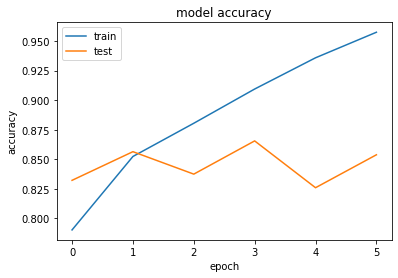

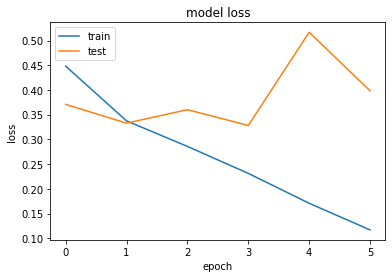

In [49]:
plotting(h5)

## Fasttext

In [50]:
from tqdm import tqdm

import os, re, csv, math, codecs

In [51]:
embeddings_index = {}
f = codecs.open('../input/fasttext/wiki.simple.vec', encoding='utf-8')
for line in tqdm(f):
    values = line.rstrip().rsplit(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('found %s word vectors' % len(embeddings_index))

111052it [00:13, 8023.99it/s]

found 111052 word vectors


In [52]:
embedding_matrix_ft = zeros((vocab_size, 100)) 
for word, index in tokenizer.word_index.items(): 
    embeddings_index = embeddings_dictionary.get(word) 
    if embeddings_index is not None: 
        embedding_matrix_ft[index] = embeddings_index


In [53]:
embedding_matrix_ft

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.038194  , -0.24487001,  0.72812003, ..., -0.1459    ,
         0.82779998,  0.27061999],
       [-0.071953  ,  0.23127   ,  0.023731  , ..., -0.71894997,
         0.86894   ,  0.19539   ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.37771001,  0.22946   , -0.30311   , ..., -0.33610001,
         0.02637   , -0.72302002],
       [ 0.99882001,  0.044     ,  0.58508003, ..., -0.54869002,
         0.15141   ,  1.36880004]])

**modèle LSTM :**

In [54]:
m6,h6=model_LSTM(X_train,y_train,100,embedding_matrix_ft)

Epoch 1/6
250/250 [==============================] - 4s 11ms/step - loss: 0.5647 - acc: 0.7097 - val_loss: 0.4718 - val_acc: 0.7764
Epoch 2/6
250/250 [==============================] - 2s 10ms/step - loss: 0.4448 - acc: 0.7931 - val_loss: 0.4333 - val_acc: 0.8074
Epoch 3/6
250/250 [==============================] - 2s 10ms/step - loss: 0.4007 - acc: 0.8178 - val_loss: 0.3892 - val_acc: 0.8279
Epoch 4/6
250/250 [==============================] - 2s 10ms/step - loss: 0.3696 - acc: 0.8352 - val_loss: 0.3697 - val_acc: 0.8357
Epoch 5/6
250/250 [==============================] - 2s 10ms/step - loss: 0.3453 - acc: 0.8472 - val_loss: 0.3578 - val_acc: 0.8429
Epoch 6/6
250/250 [==============================] - 2s 10ms/step - loss: 0.3263 - acc: 0.8562 - val_loss: 0.3298 - val_acc: 0.8585


In [55]:
score = m6.evaluate(X_test, y_test, verbose=1)
print("Test Score:", score[0]) 
print("Test Accuracy:", score[1])

313/313 [==============================] - 1s 3ms/step - loss: 0.3315 - acc: 0.8533
Test Score: 0.3315247893333435
Test Accuracy: 0.8532999753952026


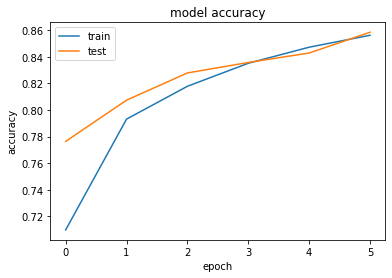

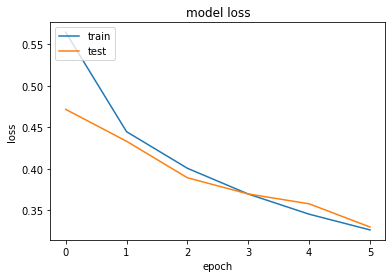

In [56]:
plotting(h6)

**modèle GRU :**

In [57]:
m7,h7=model_GRU(X_train,y_train,100,embedding_matrix_ft)

Epoch 1/6
250/250 [==============================] - 3s 10ms/step - loss: 0.5214 - acc: 0.7262 - val_loss: 0.4221 - val_acc: 0.8029
Epoch 2/6
250/250 [==============================] - 2s 8ms/step - loss: 0.3912 - acc: 0.8235 - val_loss: 0.3638 - val_acc: 0.8376
Epoch 3/6
250/250 [==============================] - 2s 9ms/step - loss: 0.3607 - acc: 0.8403 - val_loss: 0.3479 - val_acc: 0.8490
Epoch 4/6
250/250 [==============================] - 2s 8ms/step - loss: 0.3344 - acc: 0.8511 - val_loss: 0.3304 - val_acc: 0.8518
Epoch 5/6
250/250 [==============================] - 2s 8ms/step - loss: 0.3181 - acc: 0.8616 - val_loss: 0.3350 - val_acc: 0.8514
Epoch 6/6
250/250 [==============================] - 2s 8ms/step - loss: 0.2990 - acc: 0.8694 - val_loss: 0.3442 - val_acc: 0.8484


In [58]:
score = m7.evaluate(X_test, y_test, verbose=1)
print("Test Score:", score[0]) 
print("Test Accuracy:", score[1])

313/313 [==============================] - 1s 3ms/step - loss: 0.3354 - acc: 0.8499
Test Score: 0.33538323640823364
Test Accuracy: 0.8499000072479248


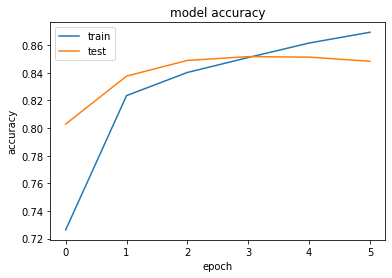

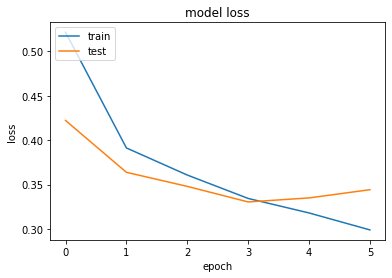

In [59]:
plotting(h7)

**modèle RNN+CNN :**

In [60]:
m8,h8=model_RNNCNN(X_train,y_train,100,embedding_matrix_ft)

Epoch 1/6
250/250 [==============================] - 3s 9ms/step - loss: 0.5925 - acc: 0.6783 - val_loss: 0.4573 - val_acc: 0.7869
Epoch 2/6
250/250 [==============================] - 2s 7ms/step - loss: 0.4246 - acc: 0.8067 - val_loss: 0.3809 - val_acc: 0.8281
Epoch 3/6
250/250 [==============================] - 2s 7ms/step - loss: 0.3627 - acc: 0.8391 - val_loss: 0.3688 - val_acc: 0.8345
Epoch 4/6
250/250 [==============================] - 2s 7ms/step - loss: 0.3179 - acc: 0.8642 - val_loss: 0.3718 - val_acc: 0.8341
Epoch 5/6
250/250 [==============================] - 2s 8ms/step - loss: 0.2780 - acc: 0.8842 - val_loss: 0.3708 - val_acc: 0.8374
Epoch 6/6
250/250 [==============================] - 2s 7ms/step - loss: 0.2530 - acc: 0.8950 - val_loss: 0.3621 - val_acc: 0.8460


In [61]:
score = m8.evaluate(X_test, y_test, verbose=1)
print("Test Score:", score[0]) 
print("Test Accuracy:", score[1])

313/313 [==============================] - 1s 3ms/step - loss: 0.3552 - acc: 0.8466
Test Score: 0.3551926016807556
Test Accuracy: 0.8465999960899353


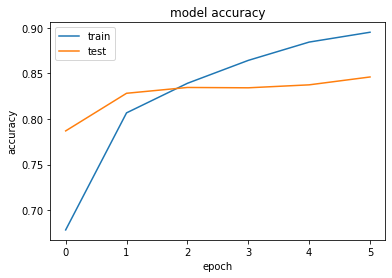

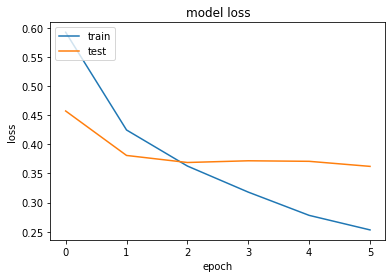

In [62]:
plotting(h8)

## TFIDF

In [63]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y,
test_size=0.20, random_state=42)

In [64]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer( use_idf=True, max_features=300)
X_train_transformed = vectorizer.fit_transform(X_train1).toarray()
X_test_transformed = vectorizer.transform(X_test1).toarray()

In [65]:
X_train_transformed.shape

(40000, 300)

In [66]:
X_train_transformed1=X_train_transformed.reshape(X_train_transformed.shape[0],X_train_transformed.shape[1],1)
X_test_transformed1=X_test_transformed.reshape(X_test_transformed.shape[0],X_test_transformed.shape[1],1)

**modèle LSTM**

In [67]:
def model_LSTM_TFIDF(X_train,y_train):
    model_rnn=Sequential()
    #model_rnn.add(Embedding(vocab_size, l, weights=[embedding_matrix],input_length=maxlen,trainable=False))
    model_rnn.add(LSTM(64))
    model_rnn.add(Dense(1,activation='sigmoid'))
    model_rnn.compile(loss='binary_crossentropy',optimizer='adam',metrics=['acc'])
    history=model_rnn.fit(X_train,y_train,epochs=6,batch_size=128,verbose=1,validation_split=0.2)
    return model_rnn,history

In [68]:
m9,h9=model_LSTM_TFIDF(X_train_transformed1,y_train1)

Epoch 1/6
250/250 [==============================] - 7s 19ms/step - loss: 0.6935 - acc: 0.5123 - val_loss: 0.6926 - val_acc: 0.5210
Epoch 2/6
250/250 [==============================] - 4s 16ms/step - loss: 0.6917 - acc: 0.5329 - val_loss: 0.6918 - val_acc: 0.5375
Epoch 3/6
250/250 [==============================] - 4s 16ms/step - loss: 0.6891 - acc: 0.5443 - val_loss: 0.6868 - val_acc: 0.5516
Epoch 4/6
250/250 [==============================] - 4s 16ms/step - loss: 0.6840 - acc: 0.5565 - val_loss: 0.6824 - val_acc: 0.5494
Epoch 5/6
250/250 [==============================] - 4s 15ms/step - loss: 0.6850 - acc: 0.5453 - val_loss: 0.6861 - val_acc: 0.5325
Epoch 6/6
250/250 [==============================] - 4s 16ms/step - loss: 0.6833 - acc: 0.5539 - val_loss: 0.6840 - val_acc: 0.5462


In [69]:
score = m9.evaluate(X_test_transformed1, y_test1, verbose=1)
print("Test Score:", score[0]) 
print("Test Accuracy:", score[1])

313/313 [==============================] - 2s 6ms/step - loss: 0.6824 - acc: 0.5588
Test Score: 0.6823720932006836
Test Accuracy: 0.5587999820709229


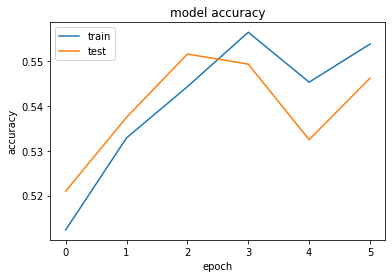

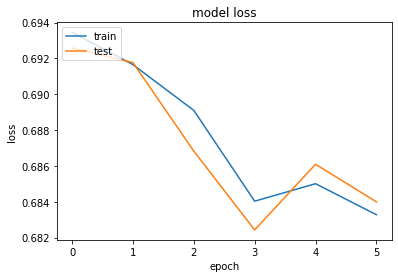

In [70]:
plotting(h9)

**modèle GRU**

In [71]:
def model_GRU_TFIDF(X_train,y_train):
    model_rnn=Sequential()
    #model_rnn.add(Embedding(vocab_size, l, weights=[embedding_matrix],input_length=maxlen,trainable=False))
    model_rnn.add(GRU(32))
    model_rnn.add(Dense(1,activation='sigmoid'))
    model_rnn.compile(loss='binary_crossentropy',optimizer='adam',metrics=['acc'])
    history=model_rnn.fit(X_train,y_train,epochs=6,batch_size=128,verbose=1,validation_split=0.2)
    return model_rnn,history

In [72]:
m10,h10=model_GRU_TFIDF(X_train_transformed1,y_train1)

Epoch 1/6
250/250 [==============================] - 5s 15ms/step - loss: 0.6928 - acc: 0.5059 - val_loss: 0.6923 - val_acc: 0.5146
Epoch 2/6
250/250 [==============================] - 3s 13ms/step - loss: 0.6869 - acc: 0.5471 - val_loss: 0.6808 - val_acc: 0.5580
Epoch 3/6
250/250 [==============================] - 3s 13ms/step - loss: 0.6810 - acc: 0.5658 - val_loss: 0.6841 - val_acc: 0.5625
Epoch 4/6
250/250 [==============================] - 4s 15ms/step - loss: 0.6788 - acc: 0.5681 - val_loss: 0.6806 - val_acc: 0.5585
Epoch 5/6
250/250 [==============================] - 3s 13ms/step - loss: 0.6757 - acc: 0.5721 - val_loss: 0.6758 - val_acc: 0.5701
Epoch 6/6
250/250 [==============================] - 3s 13ms/step - loss: 0.6745 - acc: 0.5779 - val_loss: 0.6768 - val_acc: 0.5701


In [73]:
score = m10.evaluate(X_test_transformed1, y_test1, verbose=1)
print("Test Score:", score[0]) 
print("Test Accuracy:", score[1])

313/313 [==============================] - 2s 6ms/step - loss: 0.6753 - acc: 0.5732
Test Score: 0.6752886772155762
Test Accuracy: 0.573199987411499


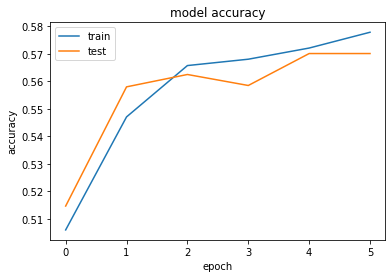

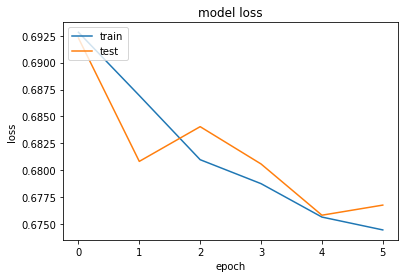

In [74]:
plotting(h10)

**modèle RNN+CNN**

In [75]:
def model_RNNCNN_TFIDF(X_train,y_train):
    modelx = Sequential()
    #modelx.add((Embedding(vocab_size,l, weights=[embedding_matrix],input_length=maxlen)))
    modelx.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
    modelx.add(MaxPooling1D(pool_size=4))
    modelx.add(LSTM(32))
    modelx.add(Dense(1, activation='sigmoid'))
    modelx.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
    history=modelx.fit(X_train,y_train,epochs=6,batch_size=128,verbose=1,validation_split=0.2)
    return modelx,history

In [76]:
m11,h11=model_RNNCNN_TFIDF(X_train_transformed1,y_train1)

Epoch 1/6
250/250 [==============================] - 4s 9ms/step - loss: 0.6924 - acc: 0.5168 - val_loss: 0.6910 - val_acc: 0.5144
Epoch 2/6
250/250 [==============================] - 2s 6ms/step - loss: 0.6872 - acc: 0.5472 - val_loss: 0.6819 - val_acc: 0.5589
Epoch 3/6
250/250 [==============================] - 2s 6ms/step - loss: 0.6783 - acc: 0.5721 - val_loss: 0.6772 - val_acc: 0.5656
Epoch 4/6
250/250 [==============================] - 2s 6ms/step - loss: 0.6693 - acc: 0.5897 - val_loss: 0.6678 - val_acc: 0.5914
Epoch 5/6
250/250 [==============================] - 2s 6ms/step - loss: 0.6658 - acc: 0.6008 - val_loss: 0.6697 - val_acc: 0.5943
Epoch 6/6
250/250 [==============================] - 2s 7ms/step - loss: 0.6623 - acc: 0.6034 - val_loss: 0.6650 - val_acc: 0.6056


In [77]:
score = m11.evaluate(X_test_transformed1, y_test1, verbose=1)
print("Test Score:", score[0]) 
print("Test Accuracy:", score[1])

313/313 [==============================] - 1s 3ms/step - loss: 0.6609 - acc: 0.6006
Test Score: 0.6609466075897217
Test Accuracy: 0.600600004196167


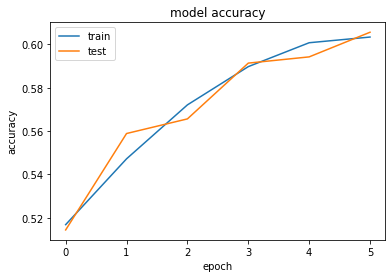

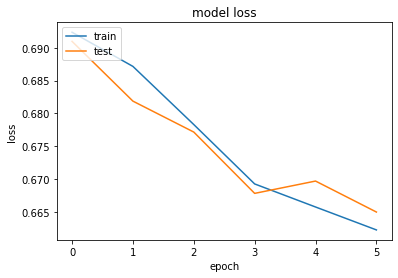

In [78]:
plotting(h11)